In [9]:
%matplotlib inline

# math and data manipulation
import numpy as np
import pandas as pd

# to handle paths
from pathlib import Path

# set random seeds 
from numpy.random import seed
from tensorflow import set_random_seed
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

from csef.model import lstm
from csef.data import preprocessing, load_data
from csef.utils import performance
from csef.model.base import BaseModel
from csef.model.base import GeneralModel

RANDOM_SEED = 2018
seed(RANDOM_SEED)
set_random_seed(RANDOM_SEED)

## Data Loading

In [2]:
data_mapping = load_data.load_data()
consumption_train = data_mapping['consumption_train']
cold_start_test = data_mapping['cold_start_test']
submission_format = data_mapping['submission_format']
meta = data_mapping['meta']

In [3]:
samp_df = load_data.sampling_data(consumption_train)

In [4]:
load_data.describe_training_data(samp_df)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


## Training

In [5]:
# scale training data
scaler = MinMaxScaler(feature_range=(-1, 1))
samp_df['consumption'] = scaler.fit_transform(samp_df['consumption'].values.reshape(-1, 1))

/home/thuongdinh/.virtualenvs/mlcsef/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
train_df, test_df = load_data.train_test_split(samp_df)

/home/thuongdinh/ws/asnet-training/ml-training/ml-energy-forecasting/csef/data/load_data.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  split_train[group_col] = ser_id
/home/thuongdinh/ws/asnet-training/ml-training/ml-energy-forecasting/csef/data/load_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  split_test[group_col] = ser_id


In [7]:
load_data.describe_training_data(train_df)

There are 10 training series totaling 280 days (6720 hours) of consumption data.


In [16]:
# Default config
n_batch = 1
n_input = 24
n_nodes = 24

### First architect

In [8]:
batch_input_shape = (n_batch, 1, n_input)
config = {
    'n_input': n_input,
    'n_nodes': n_nodes,
    'n_batch': n_batch,
    'model': [
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': n_input,
                'batch_input_shape': batch_input_shape,
                'stateful': True
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': n_input,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 12,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 6,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 1
            }
        }
    ]
}

In [14]:
scores = performance.repeat_evaluate(GeneralModel, train_df, test_df, config, scaler, n_repeats=20)

 > 0.291
 > 0.289
 > 0.287
 > 0.292
 > 0.299
 > 0.296
 > 0.292
 > 0.292
 > 0.294
 > 0.293
 > 0.295
 > 0.286
 > 0.289
 > 0.295
 > 0.298
 > 0.293
 > 0.291
 > 0.284
 > 0.293
 > 0.289


lstm: 0.292 RMSE (+/- 0.004)


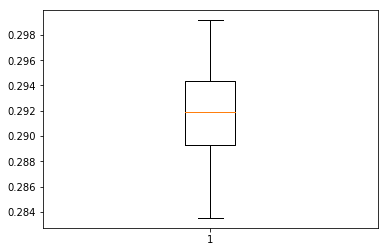

In [15]:
performance.summarize_scores('lstm', scores)

### Another architect with Dropout

In [18]:
batch_input_shape = (n_batch, 1, n_input)
config = {
    'n_input': n_input,
    'n_nodes': n_nodes,
    'n_batch': n_batch,
    'model': [
        {
            'layer_type': 'LSTM',
            'layer_config': {
                'units': n_input,
                'batch_input_shape': batch_input_shape,
                'stateful': True
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': n_input,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dropout',
            'layer_config': {
                'rate': 0.01
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 12,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dropout',
            'layer_config': {
                'rate': 0.01
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 12,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dropout',
            'layer_config': {
                'rate': 0.01
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 6,
                'activation': 'relu'
            }
        },
        {
            'layer_type': 'Dense',
            'layer_config': {
                'units': 1
            }
        }
    ]
}

In [19]:
scores = performance.repeat_evaluate(GeneralModel, train_df, test_df, config, scaler, n_repeats=20)

 > 0.279
 > 0.284
 > 0.282
 > 0.276
 > 0.277
 > 0.281
 > 0.287
 > 0.287
 > 0.276
 > 0.284
 > 0.287
 > 0.292
 > 0.289
 > 0.286
 > 0.280
 > 0.291
 > 0.283
 > 0.290
 > 0.296
 > 0.280


lstm: 0.284 RMSE (+/- 0.006)


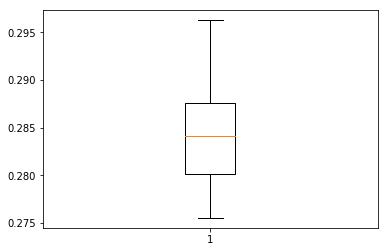

In [20]:
performance.summarize_scores('lstm', scores)